In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import cm
from math import sqrt

In [2]:
np.random.seed(1)

This notebook contains an implementation of the both linear and non-linear Conjugate Gradient descent algorithm (https://en.wikipedia.org/wiki/Conjugate_gradient_method). The reason why this algorithm is implemented in a different notebook is because its implementation is different enough and it would have been challenging to make it fit in the class structure in the first notebook. Some code in this book, however, is duplicated from the first one. 

# Linear conjugate gradient descent

Linear conjugate gradient descent is a method to solve systems of linear equations:

$Aw = b$

Finding the solution to the system of linear equations above is equivalent to finding the unique minimum of a quadratic function:

$\displaystyle\min_{\vec{w}} f(\vec{w}) = \frac{1}{2}\vec{w}^TA\vec{w}-\vec{b}^T\vec{w}$

As in the case of steepest gradient descent, this algorithm is iterative. However, instead of following the direction of maximum gradient we teack at each iteration a direction which is A-orthogonal with that of the previous iterations. This allows the algorithm to converge more directly towards the minimum. In fact, it is guaranteed that the algorithm will take at most $n$ steps, where $n$ is the dimensionality of $w$.

This notebook applies gradient descent to the linear regression case, which can be easily expressed in terms of the conjugate gradient descent algorithm:

$\begin{array}{lll} A & = & X^TX \\ w & = & \beta \\ b & = & X^TY \end{array}$

In [3]:
# Produce dataset
xlim = [-1, 2]
b0 = 0.6
b1 = 1.7
n = 11
x = np.linspace(xlim[0], xlim[1], n)
y = b1 * x + b0 + np.random.rand(n)

In [4]:
# Starting point (b0, b1)
current_params = [2.5, -7]

In [5]:
# Initialisation - this variables are mainly used to display the loss function plot
granularity = 1000
p1lim = [-10, 10]
p2lim = [-10, 10]
p1 = np.linspace(p1lim[0], p1lim[1], granularity)
p2 = np.linspace(p2lim[0], p2lim[1], granularity)
p1p1, p2p2 = np.meshgrid(p1, p2)

In [6]:
# Calculate the loss function between p1lim and p2lim
xp = np.vstack((np.ones((1, x.shape[0])), x)).T
b = np.vstack((p1p1.flatten(), p2p2.flatten()))
yp = np.dot(xp, b)
yl = np.repeat(y, granularity * granularity) \
       .reshape(y.shape[0], granularity * granularity)
l = np.mean(np.power(yl - yp, 2), axis = 0).reshape(granularity, granularity)

In [7]:
# Initialising the arrays in the system of linear equations
X = np.vstack([np.ones(x.shape[0]), x]).T
A = np.dot(X.T, X)
b = np.dot(X.T, y)

In [8]:
# Testing that we get a sensible value of (beta_0, beta_1)
beta = np.dot(np.linalg.inv(A), b)
beta

array([0.91503294, 1.71820459])

In [9]:
# Linear conjugate gradient implementation
w = [np.array(current_params[:])]
r = b - np.dot(A, np.array(current_params))
d = r
while True:
    r_prev = r
    s = np.dot(r.T, r) / np.dot(np.dot(d.T, A), d)
    w.append(list(np.array(w[-1]) + s * d)[:])
    r = b - np.dot(A, np.array(w[-1]))
    beta = np.dot(r.T, r) / np.dot(r_prev.T, r_prev)
    prev_d = d
    if np.sum(np.abs(r)) < 0.0001:
        break
    d = r + beta * d

Notice how at each iteration the algorithm descends as much possible in the corresponding direction before switching to an A-ortoghonal direction:

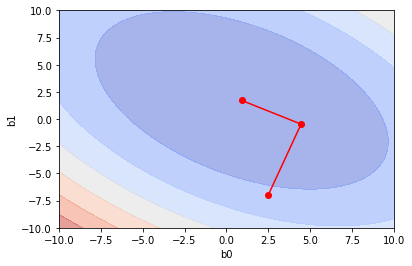

In [10]:
# Plot loss 2d and the gradient descent iterations
fig, ax = plt.subplots()
ax.contourf(p1, p2, l, cmap = cm.coolwarm, alpha = 0.5)
ax.set_xlabel('b0')
ax.set_ylabel('b1')
plt.plot(np.array(w)[:, 0], np.array(w)[:, 1], 'r-o')

## Non-linear conjugate gradient descent

Contrary to linear conjugate gradient descent, non-linear conjugate gradient descent is used to optimise a non-linear function using its gradient alone. This works when the function is quadratic around the minimum, which is the case when the loss function is twice differentiable and the second derivative is non-singular at the minimum. 

I will use the algorithm to optimise a Syblinski-Tang regression model (see the previous notebook).

In [11]:
# Gradient descent initialisation
DIVERGENCE_VALUE = 10
MAX_ITERATIONS = 10000
STOP_THRESHOLD = 0.0001

In [12]:
# Produce dataset
B1 = -2.91
B2 = -2.91
N = 100
x = np.array(range(1, N + 1))
y = (np.power(B1, 4) - 16 * np.power(B1, 2) + 5 * B1) * x
y = y + (np.power(B2, 4) - 16 * np.power(B2, 2) + 5 * B2) * x
y = 0.5 * y + 100 * np.random.rand(N)

In [13]:
# Starting point (b0, b1)
current_params = [-1, 0]

In [14]:
# Initialisation - this variables are mainly used to display the loss function plot
granularity = 1000
p1lim = [-4, 4]
p2lim = [-4, 4]
p1 = np.linspace(p1lim[0], p1lim[1], granularity)
p2 = np.linspace(p2lim[0], p2lim[1], granularity)
p1p1, p2p2 = np.meshgrid(p1, p2)

In [15]:
# Calculate the loss function between p1lim and p2lim
xp = np.vstack((x, x)).T
b = np.vstack((p1p1.flatten(), p2p2.flatten()))
b = np.power(b, 4) - 16 * np.power(b, 2) + 5 * b
yp = 0.5 * np.dot(xp, b)
yl = np.repeat(y, granularity * granularity).reshape(y.shape[0], granularity * granularity)
l = np.mean(np.power(yl - yp, 2), axis = 0).reshape(granularity, granularity)

In [16]:
# Auxiliary function to calculate gradient
def calculate_gradient(x, y, current_params):
    # Both derivatives share the rightmost part
    diff = 0
    for i in range(2):
        diff = diff +  (current_params[i] ** 4 - 16 * current_params[i] ** 2 + 5 * current_params[i]) * x
    diff = y - 0.5 * diff
    # Partial derivative with respect to b_1
    d_b1 = -np.mean(np.multiply(x, 
                                np.multiply(4 * current_params[0] ** 3 - 32 * current_params[0] + 5, 
                                            diff)))
    # Partial derivative with respect to b_2
    d_b2 = -np.mean(np.multiply(x, 
                                np.multiply(4 * current_params[1] ** 3 - 32 * current_params[1] + 5, 
                                            diff)))

    return [d_b1, d_b2]

In [17]:
# Auxiliary function for backtracking line search
def line_search(current_params, gradient, beta):
    current_params = np.array(current_params)
    
    def _f(params):
        b = np.power(params, 4) - 16 * np.power(params, 2) + 5 * np.array(params)
        yp = 0.5 * np.dot(xp, b)
        return np.mean(np.power(y - yp, 2), axis = 0)
        
    t = 1.0
    while _f(current_params - t * gradient) > _f(current_params) - \
                                              t/2.0 * norm(gradient, ord = 2) ** 2:
        t = t * beta
        
    return t

In [18]:
# Non-linear conjugate gradient implementation
w = [np.array(current_params[:])]
# In the first iteration we used the direction of maximum gradient
gradient = np.array(calculate_gradient(x, y, current_params))
t = line_search(current_params, gradient, 0.9999)
current_params = list(np.array(w[-1]) - t * np.array(gradient))[:]
# In the following steps:
prev_s = gradient
prev_grad = np.array(gradient)
it = 0
# 1 Calculate the steepest direction
while it == 0 or (np.sum(np.abs(np.array(current_params) - np.array(w[-1]))) > STOP_THRESHOLD and \
                  np.all(np.array(current_params) - np.array(w[-1]) < DIVERGENCE_VALUE) and \
                  it < MAX_ITERATIONS):
    w.append(current_params)
    it = it + 1
    gradient = np.array(calculate_gradient(x, y, current_params))
    # 2 Compute the beta value to find the conjugate direction
    beta = np.dot(gradient, gradient - prev_grad) / (np.dot(prev_grad, prev_grad))
    beta = max(0, beta) # This ensures a reset when conjugacy is lost 
    # 3 Update the conjugate direction 
    s = gradient + beta * prev_grad
    # 4 Line search
    t = line_search(current_params, gradient, 0.9)
    current_params = list(np.array(w[-1]) - t * np.array(gradient))[:]
    prev_s = s
    prev_grad = gradient
w.append(current_params)

11 iterations
Minimum at [-2.7554695235089235, -3.0577524861303798]


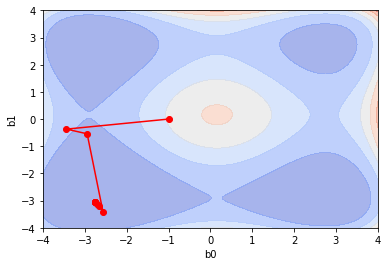

In [19]:
# Plot loss 2d and the gradient descent iterations
fig, ax = plt.subplots()
ax.contourf(p1, p2, l, cmap = cm.coolwarm, alpha = 0.5)
ax.set_xlabel('b0')
ax.set_ylabel('b1')
plt.plot(np.array(w)[:, 0], np.array(w)[:, 1], 'r-o')
print(str(len(w)) + " iterations")
print("Minimum at " + str(w[-1]))